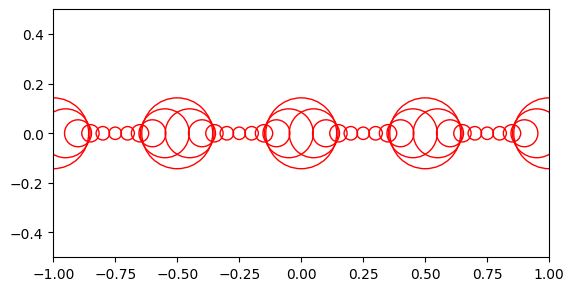

[0.14285714 0.09851033 0.05434422 0.03496653 0.02713794 0.025
 0.02713794 0.03496653 0.05434422 0.09851033 0.14285714 0.09851033
 0.05434422 0.03496653 0.02713794 0.025      0.02713794 0.03496653
 0.05434422 0.09851033 0.14285714 0.09851033 0.05434422 0.03496653
 0.02713794 0.025      0.02713794 0.03496653 0.05434422 0.09851033
 0.14285714 0.09851033 0.05434422 0.03496653 0.02713794 0.025
 0.02713794 0.03496653 0.05434422 0.09851033 0.14285714]


In [1]:

from collections import defaultdict
from dimod import SimulatedAnnealingSampler
import numpy as np
import matplotlib.pyplot as plt

# Function and its derivatives
def f(x):
    return np.sin(2*np.pi*x)

def f_prime_norm(x):
    return np.cos(2*np.pi*x)

def f_second_norm(x):
    return -np.sin(2*np.pi*x)

def comp_radius(x, min, max):
    k1 = min/(max-min)
    k2 = max*min/(max-min) 
    area = k2/(f_second_norm(x)**2+k1)
    return area


# def f_second(x):
#     return -4 * (np.pi**2) * np.sin(2 * np.pi * x) -64 * (np.pi**2) *np.cos(8*np.pi*x)

# def f_second_norm(x):
#     res = f_second(x)
#     return res/np.max(abs(res))

# Initial uniform mesh
x_initial = np.linspace(-1, 1, 21)
y_initial = f(x_initial)
# x_mid = np.zeros(9)
# for i in range(9):
#     x_mid[i] = (x_initial[i]+x_initial[i+1])/2
# Define mesh points
num_points = 41
x_tot = np.linspace(-1, 1, num_points)  # Full grid

# Parameters
F = 28  # Max number of nodes
beta = 1  # Enforcing parameter for sparsity
alpha = 2  # Interference enforcing parameter
area_weight = 5  # Area enforcement
min_radius = 1 / 40
max_radius = 1 / 7

# Initialize QUBO matrix
Q = defaultdict(int)

# Compute radii for all points
radii = np.array([comp_radius(x, min_radius, max_radius) for x in x_tot])

# Define the QUBO matrix more efficiently
for i in range(num_points):
    area = radii[i] ** 2 * np.pi
    Q[(i, i)] = -area_weight * area + beta * (1 - 2 * F)

    for j in range(i + 1, num_points):  # Avoid duplicate calculations
        interference = max(0, radii[i] + radii[j] - abs(x_tot[i] - x_tot[j]))
        Q[(i, j)] = 2 * beta + alpha * interference


fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
for j in range(num_points):
    ax.add_patch(plt.Circle((x_tot[j], 0), radii[j], color='r', fill=False))


# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()
plt.gca().set_aspect('equal')
plt.xlim((-1,1))
plt.ylim((-1/2,1/2))
plt.show()
print(radii)




In [2]:

# Define the sampler that will be used to run the problem
#sampler = EmbeddingComposite(DWaveSampler())
# Instantiate the sampler
sampler = SimulatedAnnealingSampler()

# Run the problem on the sampler and print the results
sampleset = sampler.sample_qubo(Q,
                                 num_reads = 100)
#print(sampleset) #prints energy, number of occurencies and 
result = sampleset.first.sample #lowest energy sample

#print(first)
#for k in range(9):
    #print(result[k])

x_adapt = [x_tot[k] for k in range(len(x_tot)) if result[k] == 1]

print(x_initial)
print(x_adapt)


[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
[np.float64(-1.0), np.float64(-0.95), np.float64(-0.85), np.float64(-0.8), np.float64(-0.75), np.float64(-0.7), np.float64(-0.6499999999999999), np.float64(-0.5), np.float64(-0.3999999999999999), np.float64(-0.29999999999999993), np.float64(-0.25), np.float64(-0.19999999999999996), np.float64(-0.1499999999999999), np.float64(-0.04999999999999993), np.float64(0.10000000000000009), np.float64(0.15000000000000013), np.float64(0.20000000000000018), np.float64(0.25), np.float64(0.30000000000000004), np.float64(0.3500000000000001), np.float64(0.40000000000000013), np.float64(0.55), np.float64(0.6500000000000001), np.float64(0.7000000000000002), np.float64(0.75), np.float64(0.8), np.float64(0.8500000000000001), np.float64(1.0)]


0.0012765795748245086
0.0007343467912269816


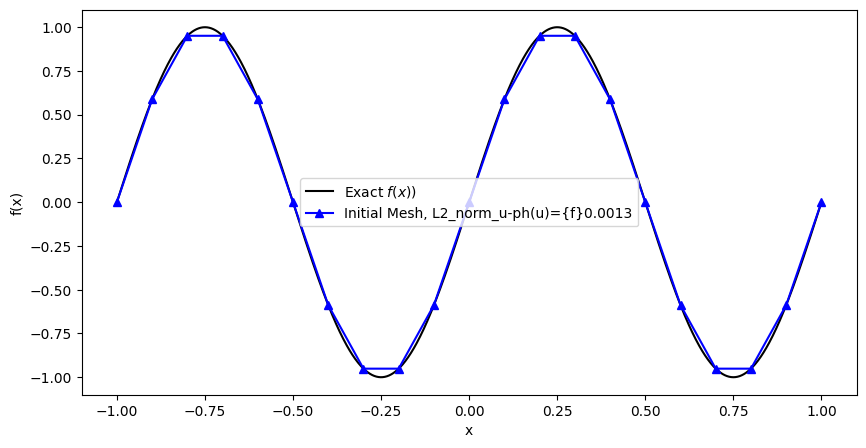

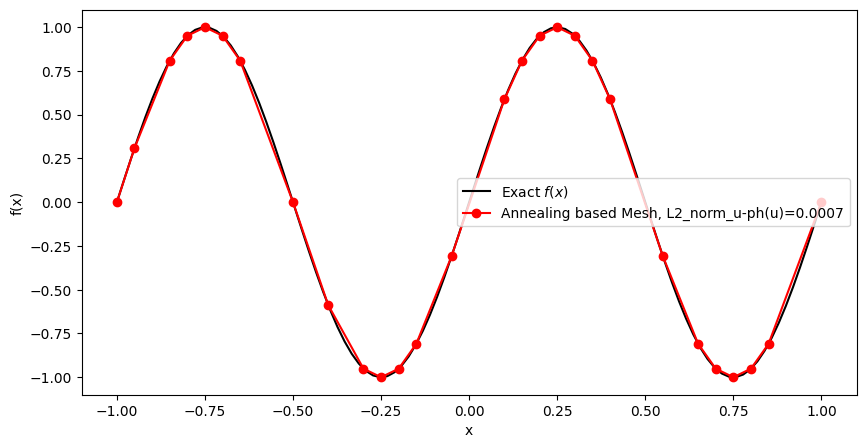

In [7]:
from scipy.integrate import quad

y_adaptive = f(np.array(x_adapt))
f_interp_init = lambda xx: np.interp(xx, x_initial, y_initial)
f_integr_1 = lambda xx: (f(xx)-f_interp_init(xx))**2

err_i, acc_i = quad(f_integr_1 , -1, 1, points=x_initial)
print(err_i)

f_interp_adapt = lambda xx: np.interp(xx, x_adapt, y_adaptive)
f_integr_2 = lambda xx: (f(xx)-f_interp_adapt(xx))**2

err_a, acc_a = quad(f_integr_2 , -1, 1, points=x_adapt)
print(err_a)



# Plotting the initial and adapted meshes
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(-1, 1, 1000),f(np.linspace(-1, 1, 1000)), 'k-', label="Exact $f(x))$")
plt.plot(x_initial, y_initial, 'b^-', label="Initial Mesh, L2_norm_u-ph(u)={f}"+format(err_i, '.4f'))
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(-1, 1, 100), f(np.linspace(-1, 1, 100)), 'k-', label="Exact $f(x)$")
plt.plot(x_adapt, y_adaptive, 'ro-', label="Annealing based Mesh, L2_norm_u-ph(u)="+format(err_a, '.4f'))
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

